In [1]:
# Import libraries to use 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings


In [2]:
# Definitions

# Function to generate netlist for ngspice
def generatenetlist(filename,Ic,N,Imax):
    with open(filename, 'w') as output:
        output.write(f'* Netlist for {N} stacked tapes\n') # Name of the circuit as a comment
        output.write('I1 0 1 100\n') # Current source

        Rt = np.zeros(N)+0.5E-6
        n = np.zeros(N)+30 # n for power law
        # Creating nodes for each resitor and inductor
        for i in range(N):
            j = i+1
            k = i+2
            output.write(f'R{j} 1 {k} {Rt[i]}\n')
            output.write(f'B{j} {k} 0 V=100E-6*pow((I(B{j})/{Ic[i]}),{n[i]})\n')
    
        output.write(f'.dc I1 0 {Imax} 5\n')
        output.write('.print dc  V(1) \n') # Since the voltage is clamped we only need the data of one tape
        output.write('.end\n')

In [3]:
# Function to run netlist in ngspice and get data
def gettingdata(filename):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    in_data = False
    in_data_after = False
    count_dash_line = 0
    count_space = 0
    data = []
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
            if in_data:
                if line.strip() == '':
                    in_data = False
                    count_dash_line = 0
                    count_space += 1
                    continue
                tmp = [float(x) for x in line.split()]
                data.append(tmp)

            if in_data_after:
                if line.strip() == '':
                    in_data_after = False
                    count_dash_line = 0
                    continue
                tmp = [float(x) for x in line.split()]
                data.append(tmp)

            if '----' in line:
                count_dash_line += 1
            if count_dash_line == 2 and not in_data:
                in_data = True

            if count_dash_line == 1 and count_space == 1 and not in_data_after:
                in_data_after = True

    data = np.asanyarray(data)
    Icable = data[:,1]
    Vt =  data[:,2] 
    return Icable,Vt 

In [4]:
# Fitting only exponential with 10 microV as voltage criteria

def model_func_exp10(I,Ic,n):
    V0 = 10E-6 # Considering the electric field criterion 10uV/m with length = 1 m
    return V0*(I/Ic)**n

def fit_exp10(I,V,Ic0,n0): #(Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func_exp10, I, V,(Ic0,n0))
    Ic,n = opt_parms
    return Ic,n

In [32]:
def plotting():
    Icable,Vt = gettingdata(filename)
        
    # Second fitting removing resistive part
    Rt = 0.5E-6/N # Terminal resistance over number of tapes
    Vt_exp = Vt-Icable*Rt # Removing resistive part

    Vt_lim = []
    Icable_lim = []

    # Voltage limit
    for l in range(len(Vt_exp)):
        if Vt_exp[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt_exp[l])
            Icable_lim.append(Icable[l])

    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)

    # Exponential fitting
    Ic0,n0 = 100*N,30 # Initial values to fit exponential part
    Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
    #print(Ic_e,n_e)
    
    # Getting curve from fitting 
    Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
    # Plotting
    print(tag+f'Fit {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
    plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
    plt.plot(Icable_lim,Vt_fit_exp,label = tag + f'Fit {sigma[i]}') 

# First case: 10 tapes with n samples for each standard deviation

Assuptions:
- Voltage criterion for fitting model is 10 microV but in ngspice is 100 microV.
- The cutoff total voltage is 100 microV. 
- Ramping current up to 125% of the ideal critical current of the cable. 

In [37]:
# This is the main code to generate netlists, run in ngspice and get the average arrays with fitting 

def main(Nsample):
    # Generating normal distributions with different standard deviations
    #%matplotlib inline
    warnings.filterwarnings("ignore") # Force shutting down of warnings

    # Start timer 
    start = timeit.default_timer()

    N = 10 # Number of tapes
    mu = 100 # mean value for Ic
    sigma = np.array([1,3,5,7.5,10,15,20,25,30,40,50,60])
    #Nsample = 20 # Number of samples per each standard deviation 
    Imax = 1.25*N*mu # I added a some overcurrent of 25% for the cable current

    Ic_array = [] # Array to save Ic from each sample
    sd_Ic = []
    n_array = [] # Array to save n from each sample
    sd_n = []
    Error_fit_array = [] # Array to save errors from fitting
    sd_error = []
    max_fiterror_index = []
    min_fiterror_index = []

    '''
    # random1 = int(random.random()*10)
    random1 = 0
    random2 = int(random.random()*10)
    '''

    for i in range(len(sigma)):
        Ic_samples = []
        n_samples = []
        error_samples = []                      
        for j in range(Nsample):
            filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
            #filename = f'{N} tapes sd {sigma[i]} sample {j+1}.cir'
            Ic_dist = np.random.normal(mu, sigma[i], N)
            # Forcing data to be possitive in case Ic is negative
            for k in range(N):
                if Ic_dist[k] <= 0:
                    Ic_dist[k] = 10. 

            # Generating netlist for specific sample
            generatenetlist(filename,Ic_dist,N,Imax) 

            # Running netlist in ngspice and getting data (cable current and total voltage)
            Icable,Vt = gettingdata(filename)

            # Second fitting removing resistive part
            Rt = 0.5E-6/N # Terminal resistance over number of tapes
            Vt_exp = Vt-Icable*Rt # Removing resistive part

            Vt_lim = []
            Icable_lim = []

            # Voltage limit
            for l in range(len(Vt_exp)):
                if Vt_exp[l] <= 100e-6: # Limit of the total voltage
                    Vt_lim.append(Vt_exp[l])
                    Icable_lim.append(Icable[l])

            Vt_lim = np.array(Vt_lim)
            Icable_lim = np.array(Icable_lim)

            # Exponential fitting
            Ic0,n0 = 100*N,30 # Initial values to fit exponential part
            Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
            #print(Ic_e,n_e)

            # Saving data from sample
            Ic_samples.append(Ic_e)
            n_samples.append(n_e)   

            # Getting curve from fitting 
            Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)

            # Calculating fitting error
            Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
            error_samples.append(Error)

            '''
            # Plotting randomly one case
            if i == random1 and j == random2:
                plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
                plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit {sigma[i]}') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
                plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
                plt.xlabel('Cable current (A)')
                plt.ylabel('Voltage (V)')
                plt.title(f'1 m - {N} stacked tapes different Ic')
                plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
                plt.show()
                plt.savefig('x.png')
                print(f'Fit {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
            '''

        # Arrays for Ic, n, and fit error for samples
        Ic_samples = np.array(Ic_samples)
        n_samples = np.array(n_samples) 
        error_samples = np.array(error_samples)

        # Saving Max error index per each standard deviation
        max_fiterror_index.append(np.argmax(error_samples))
        min_fiterror_index.append(np.argmin(error_samples))

        # Calculating averages and standard deviation of samples
        Ic_array.append(np.average(Ic_samples))
        sd_Ic.append(np.std(Ic_samples))

        n_array.append(np.average(n_samples))
        sd_n.append(np.std(n_samples))

        Error_fit_array.append(np.average(error_samples))
        sd_error.append(np.std(error_samples))

    # Converting averages and standard deviations into array type
    Ic_array = np.array(Ic_array)
    sd_Ic = np.array(sd_Ic)

    n_array = np.array(n_array)
    sd_n = np.array(sd_n)

    Error_fit_array = np.array(Error_fit_array)
    sd_error = np.array(sd_error)

    max_fiterror_index = np.array(max_fiterror_index)
    min_fiterror_index = np.array(min_fiterror_index)

    # Saving data from average and sd arrays
    fileaveragename = f'{N} tapes - {Nsample} samples'
    with open(fileaveragename, 'w') as output:
        output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
        for i in range(len(sigma)):
            output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')

    # Stop timer
    stop = timeit.default_timer()

    print('Computing time: ', stop - start)

In [38]:
# In this part we define the number of samples that we want to test and run the main code for each case
Nsample = np.array([10,20,50,100,200,500,1000])

for i in range(len(Nsample)):
    main(Nsample[i])


Computing time:  3.783915529999831
Computing time:  6.634735317999912
Computing time:  17.15998248300002
Computing time:  33.366032671000085
Computing time:  73.80552369999987
Computing time:  164.88097156599997
Computing time:  392.99010761299996


In [45]:
# This definition helps to read the files where we saved all the averaged data from each Nsample case
def readfilensample(Nsample):
    fileaveragename = f'{N} tapes - {Nsample} samples'
    with open(fileaveragename) as f:
        lines_after_first = f.readlines()[1:]
        data = []
        for line in lines_after_first:
            #print(line)
            tmp = [float(x) for x in line.split('\t ')]
            data.append(tmp)
    data = np.asanyarray(data)
    return data

# Comparison of the results for different number of samples

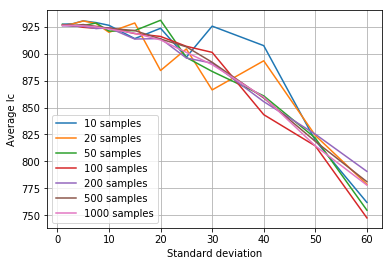

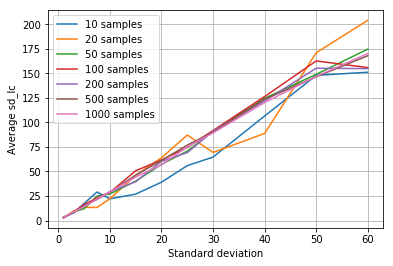

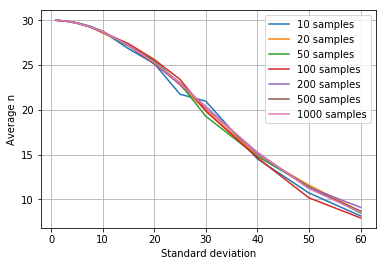

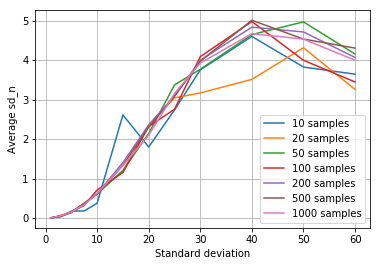

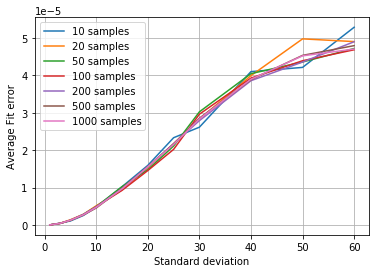

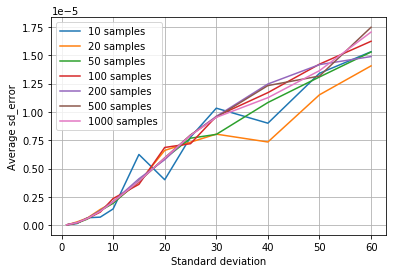

In [53]:

%matplotlib inline
Nsamples = np.array([10,20,50,100,200,500,1000])
#Nsamples = np.array([200,500,1000])
for i in range(len(Nsamples)):
    data = readfilensample(Nsamples[i])
    Ic_array = data[:,1]
    plt.plot(sigma,Ic_array, label = f'{Nsamples[i]} samples')
plt.ylabel('Average Ic')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.show()    

for i in range(len(Nsamples)):
    data = readfilensample(Nsamples[i])
    sd_Ic = data[:,2]
    plt.plot(sigma,sd_Ic, label = f'{Nsamples[i]} samples')
plt.ylabel('Average sd_Ic')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.show()

for i in range(len(Nsamples)):
    data = readfilensample(Nsamples[i])
    n_array = data[:,3]
    plt.plot(sigma,n_array, label = f'{Nsamples[i]} samples')
plt.ylabel('Average n')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.show()

for i in range(len(Nsamples)):
    data = readfilensample(Nsamples[i])
    sd_n = data[:,4]
    plt.plot(sigma,sd_n, label = f'{Nsamples[i]} samples')
plt.ylabel('Average sd_n')
plt.xlabel('Standard deviation')
plt.legend()
plt.grid()
plt.show()    
    
for i in range(len(Nsamples)):
    data = readfilensample(Nsamples[i])
    Error_fit_array = data[:,5]
    plt.plot(sigma,Error_fit_array, label = f'{Nsamples[i]} samples')
plt.ylabel('Average Fit error')
plt.xlabel('Standard deviation')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.show()

for i in range(len(Nsamples)):
    data = readfilensample(Nsamples[i])
    sd_error = data[:,6]
    plt.plot(sigma,sd_error, label = f'{Nsamples[i]} samples')
plt.ylabel('Average sd_error')
plt.xlabel('Standard deviation')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()
plt.show()
    #max_fiterror_index = data[:,7]
    #min_fiterror_index = data[:,8]

# In this part we can run a single number of samples and generate plots

In [54]:
# Generating normal distributions with different standard deviations
#%matplotlib inline
warnings.filterwarnings("ignore") # Force shutting down of warnings

# Start timer 
start = timeit.default_timer()
 
N = 10 # Number of tapes
mu = 100 # mean value for Ic
sigma = np.array([1,3,5,7.5,10,15,20,25,30,40,50,60])
Nsample = 500 # Number of samples per each standard deviation 
Imax = 1.25*N*mu # I added a some overcurrent of 25% for the cable current

Ic_array = [] # Array to save Ic from each sample
sd_Ic = []
n_array = [] # Array to save n from each sample
sd_n = []
Error_fit_array = [] # Array to save errors from fitting
sd_error = []
max_fiterror_index = []
min_fiterror_index = []

'''
# random1 = int(random.random()*10)
random1 = 0
random2 = int(random.random()*10)
'''

for i in range(len(sigma)):
    Ic_samples = []
    n_samples = []
    error_samples = []                      
    for j in range(Nsample):
        filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
        #filename = f'{N} tapes sd {sigma[i]} sample {j+1}.cir'
        Ic_dist = np.random.normal(mu, sigma[i], N)
        # Forcing data to be possitive in case Ic is negative
        for k in range(N):
            if Ic_dist[k] <= 0:
                Ic_dist[k] = 10. 
        
        # Generating netlist for specific sample
        #generatenetlist(filename,Ic_dist,N,Imax) 
        
        # Running netlist in ngspice and getting data (cable current and total voltage)
        Icable,Vt = gettingdata(filename)
        
        # Second fitting removing resistive part
        Rt = 0.5E-6/N # Terminal resistance over number of tapes
        Vt_exp = Vt-Icable*Rt # Removing resistive part

        Vt_lim = []
        Icable_lim = []
        
        # Voltage limit
        for l in range(len(Vt_exp)):
            if Vt_exp[l] <= 100e-6: # Limit of the total voltage
                Vt_lim.append(Vt_exp[l])
                Icable_lim.append(Icable[l])

        Vt_lim = np.array(Vt_lim)
        Icable_lim = np.array(Icable_lim)

        # Exponential fitting
        Ic0,n0 = 100*N,30 # Initial values to fit exponential part
        Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
        #print(Ic_e,n_e)
        
        # Saving data from sample
        Ic_samples.append(Ic_e)
        n_samples.append(n_e)   
        
        # Getting curve from fitting 
        Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
        
        # Calculating fitting error
        Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
        error_samples.append(Error)
        
        '''
        # Plotting randomly one case
        if i == random1 and j == random2:
            plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
            plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit {sigma[i]}') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
            plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
            plt.xlabel('Cable current (A)')
            plt.ylabel('Voltage (V)')
            plt.title(f'1 m - {N} stacked tapes different Ic')
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
            plt.show()
            plt.savefig('x.png')
            print(f'Fit {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
        '''
    
    # Arrays for Ic, n, and fit error for samples
    Ic_samples = np.array(Ic_samples)
    n_samples = np.array(n_samples) 
    error_samples = np.array(error_samples)
    
    # Saving Max error index per each standard deviation
    max_fiterror_index.append(np.argmax(error_samples))
    min_fiterror_index.append(np.argmin(error_samples))
    
    # Calculating averages and standard deviation of samples
    Ic_array.append(np.average(Ic_samples))
    sd_Ic.append(np.std(Ic_samples))
    
    n_array.append(np.average(n_samples))
    sd_n.append(np.std(n_samples))
    
    Error_fit_array.append(np.average(error_samples))
    sd_error.append(np.std(error_samples))

# Converting averages and standard deviations into array type
Ic_array = np.array(Ic_array)
sd_Ic = np.array(sd_Ic)

n_array = np.array(n_array)
sd_n = np.array(sd_n)

Error_fit_array = np.array(Error_fit_array)
sd_error = np.array(sd_error)

max_fiterror_index = np.array(max_fiterror_index)
min_fiterror_index = np.array(min_fiterror_index)

# Saving data from average and sd arrays
fileaveragename = f'{N} tapes - {Nsample} samples'
with open(fileaveragename, 'w') as output:
    output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
    for i in range(len(sigma)):
        output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')

# Stop timer
stop = timeit.default_timer()

print('Computing time: ', stop - start)

Computing time:  211.61434406700027


Best Fit 1.0: Ic = 924.1491507528802, n = 30.018317377957782, Fit-error = 6.858954764739296e-09
Worst Fit 1.0: Ic = 927.4224258564126, n = 29.981024951705397, Fit-error = 1.660644412844127e-07


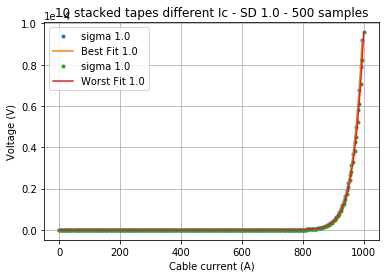

Best Fit 3.0: Ic = 920.6369748530085, n = 29.994571561183914, Fit-error = 9.620794517045405e-08
Worst Fit 3.0: Ic = 928.8871922703694, n = 29.6410099146068, Fit-error = 1.42086435744716e-06


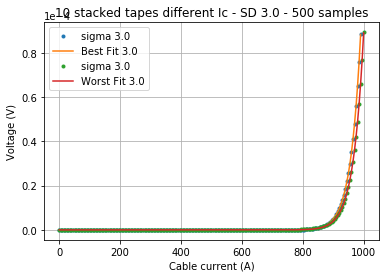

Best Fit 5.0: Ic = 927.6059071536455, n = 29.993422399474973, Fit-error = 1.1061304523477939e-07
Worst Fit 5.0: Ic = 944.3479476968505, n = 29.071955315718373, Fit-error = 3.5598484010186313e-06


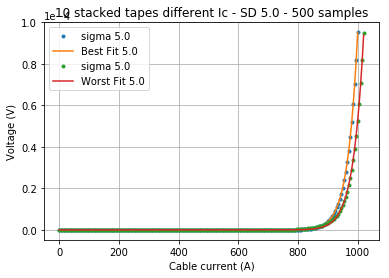

Best Fit 7.5: Ic = 974.0260728350612, n = 29.93624224476991, Fit-error = 3.454971482536587e-07
Worst Fit 7.5: Ic = 904.894028676086, n = 26.29919961971455, Fit-error = 1.0805091838505748e-05


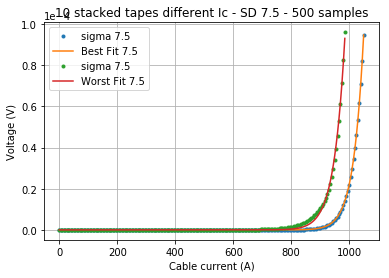

Best Fit 10.0: Ic = 959.2940244648134, n = 29.845249760454543, Fit-error = 7.535739507089412e-07
Worst Fit 10.0: Ic = 950.4817916098117, n = 25.611680653607948, Fit-error = 1.4828052141774225e-05


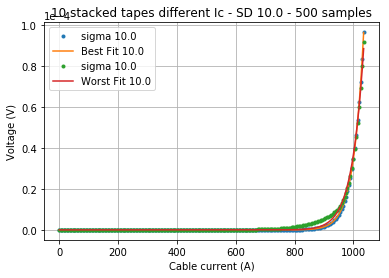

Best Fit 15.0: Ic = 880.1186250496597, n = 29.592147276718055, Fit-error = 1.754627816863086e-06
Worst Fit 15.0: Ic = 809.8794887154123, n = 21.805512660762414, Fit-error = 2.325585522793912e-05


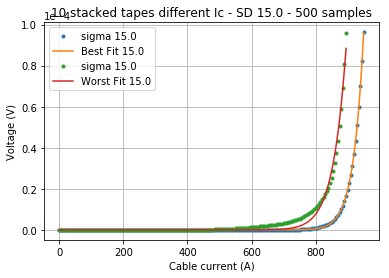

Best Fit 20.0: Ic = 915.5703181098878, n = 29.053144893114652, Fit-error = 4.043749639079465e-06
Worst Fit 20.0: Ic = 860.840420385946, n = 16.01379075553269, Fit-error = 3.982893773988813e-05


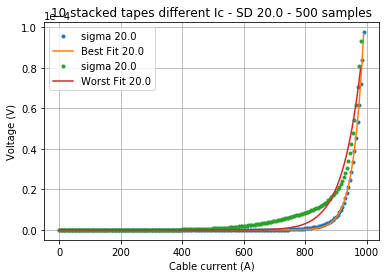

Best Fit 25.0: Ic = 1011.5134973373655, n = 29.012131188719586, Fit-error = 3.3039112313087384e-06
Worst Fit 25.0: Ic = 857.4190343573596, n = 15.99787308633637, Fit-error = 5.200337027807213e-05


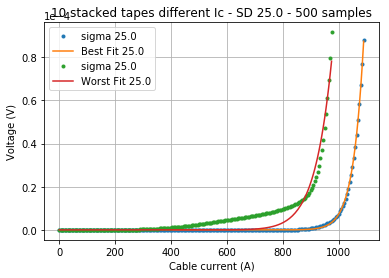

Best Fit 30.0: Ic = 948.4522288058627, n = 28.051020688839973, Fit-error = 6.772192111916778e-06
Worst Fit 30.0: Ic = 886.706140330306, n = 13.907962388598406, Fit-error = 6.101602018374992e-05


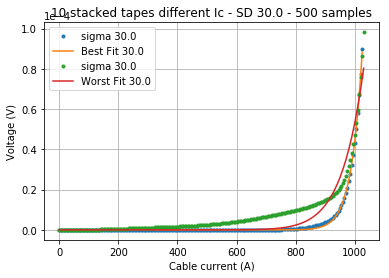

Best Fit 40.0: Ic = 942.5814667600021, n = 27.444799503367275, Fit-error = 7.626040360101878e-06
Worst Fit 40.0: Ic = 673.5127008666677, n = 6.7756472143452084, Fit-error = 7.357032253476291e-05


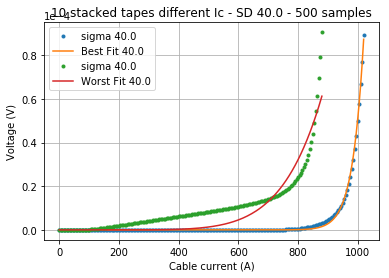

Best Fit 50.0: Ic = 1138.8948300926813, n = 5.427388023848324, Fit-error = 4.192204695348978e-06
Worst Fit 50.0: Ic = 758.6344430500421, n = 5.569444251195305, Fit-error = 9.30813403808809e-05


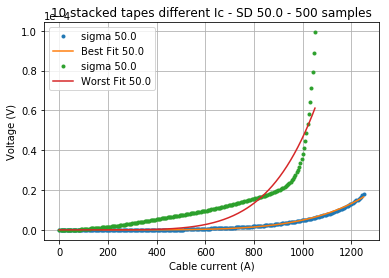

Best Fit 60.0: Ic = 1398.1722917115762, n = 4.28976691277515, Fit-error = 1.4662153201273969e-06
Worst Fit 60.0: Ic = 1000.0, n = 30.0, Fit-error = 0.0001796274449933697


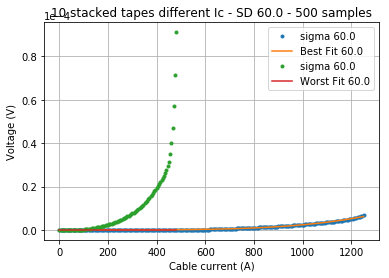

Computing time:  5.062906999000006


In [56]:
# Generating plots of the worst fitting cases for each standard deviation
%matplotlib inline

# Start timer 
start = timeit.default_timer()


for i in range(len(sigma)):                
    for j in range(Nsample):
        filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
        
        if j == min_fiterror_index[i]:
            tag = 'Best '
            plotting()
            
    for j in range(Nsample):
        filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'        
        if j == max_fiterror_index[i]:
            tag = 'Worst '
            plotting()
            
    plt.xlabel('Cable current (A)')
    plt.ylabel('Voltage (V)')
    plt.title(f'{N} stacked tapes different Ic - SD {sigma[i]} - {Nsample} samples')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
    plt.legend()
    plt.grid()
    plt.show()
# Stop timer
stop = timeit.default_timer()

print('Computing time: ', stop - start)

## Plotting absolute values of Ic, n, and fitting error

- We calculated the average and standard deviation for Ic distribution of the samples corresponding to each standard deviation.
- The standard deviation of the average is reported as error bars in the plots.

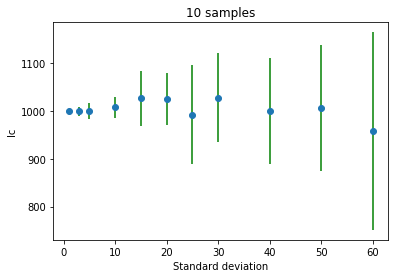

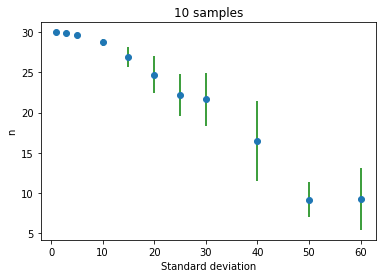

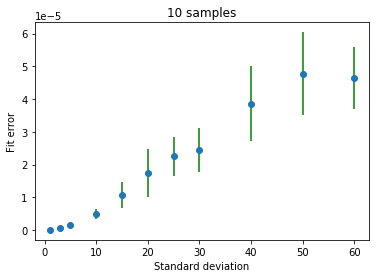

In [38]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()

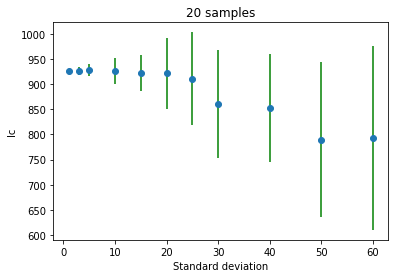

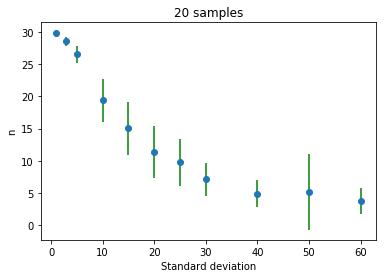

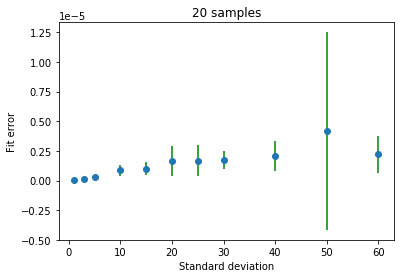

In [7]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()


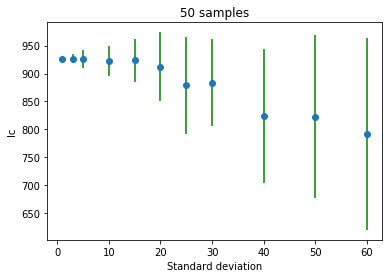

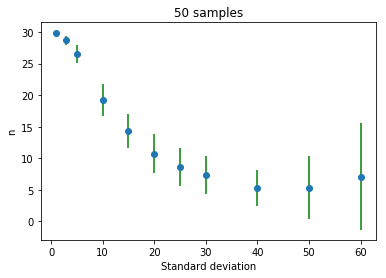

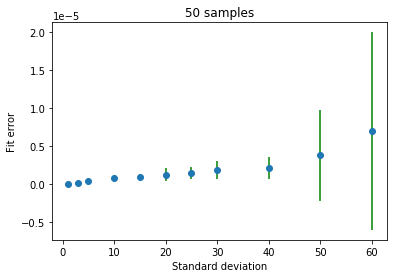

In [13]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()



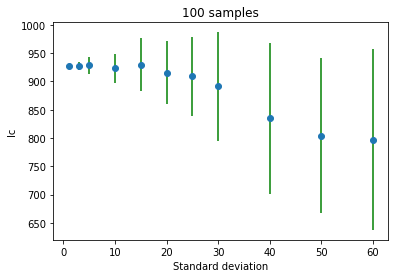

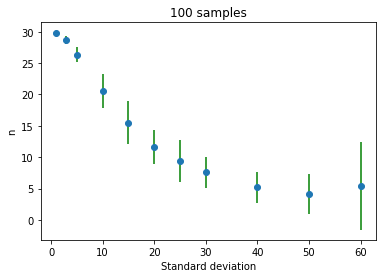

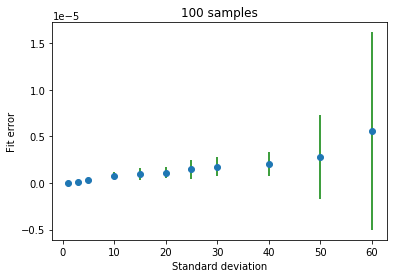

In [15]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()



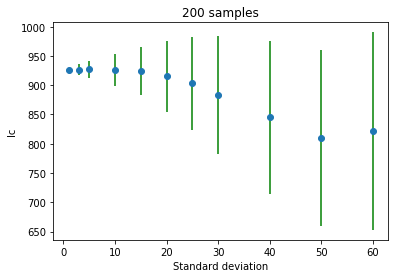

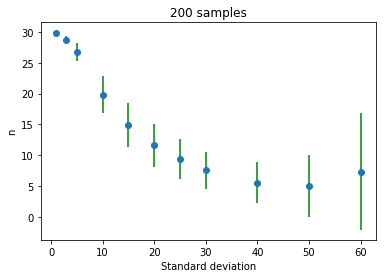

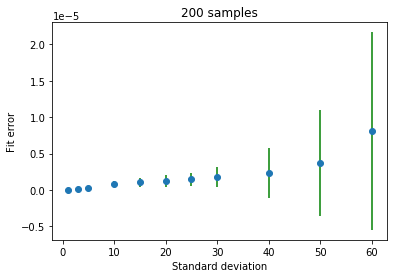

In [17]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()



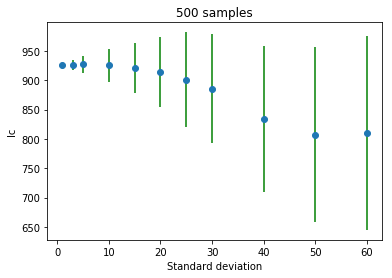

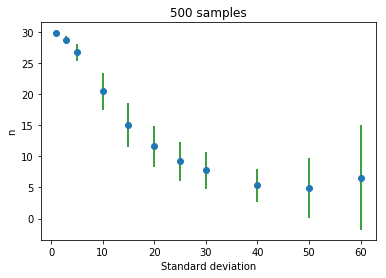

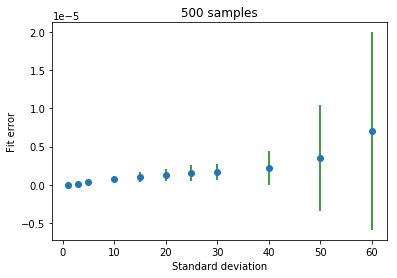

In [19]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()

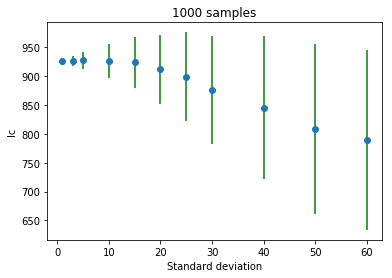

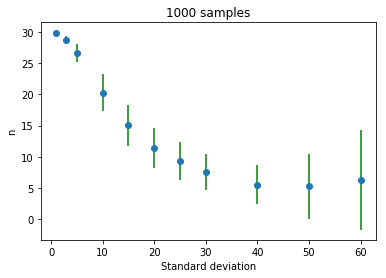

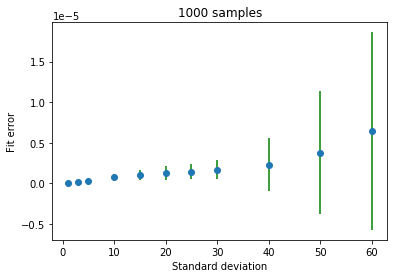

In [21]:
# Plotting absolute values and its standar deviation as error bars 
%matplotlib inline

plt.errorbar(sigma, Ic_array, yerr=sd_Ic,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Ic')
plt.show()

plt.errorbar(sigma, n_array, yerr=sd_n,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('n')
plt.show()

plt.errorbar(sigma, Error_fit_array, yerr=sd_error,fmt='o', ecolor='g')
plt.title(f'{Nsample} samples')
plt.xlabel('Standard deviation')
plt.ylabel('Fit error')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
plt.show()

## Plotting a few cases with standard deviation of 1 A

- Selecting cases from the 500 samples population case.

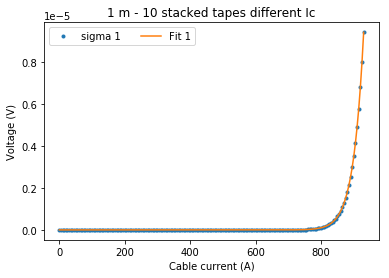

Fit 1: Ic = 931.8439664514221, n = 29.930920850176047, Fit-error = 1.0148583919509743e-08


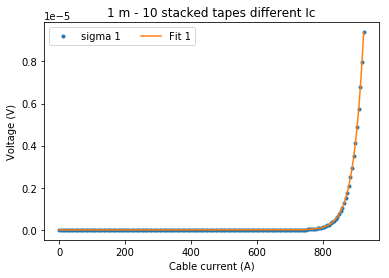

Fit 1: Ic = 926.9724381980201, n = 29.964289949049, Fit-error = 6.239213169050255e-09


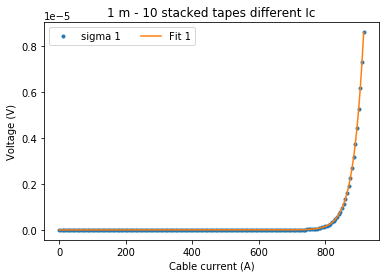

Fit 1: Ic = 919.6200780950562, n = 29.876392372970265, Fit-error = 1.4790166943523586e-08


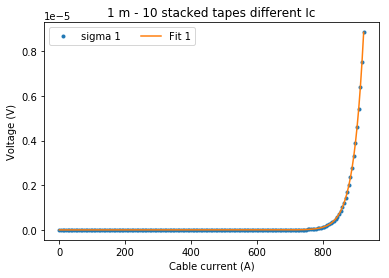

Fit 1: Ic = 928.8030801520512, n = 29.868575781073787, Fit-error = 1.6231466743733902e-08


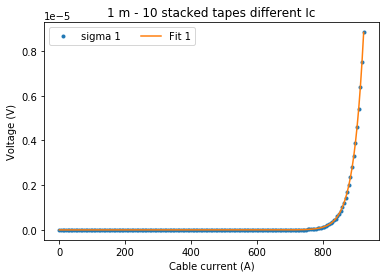

Fit 1: Ic = 928.8815822687475, n = 29.77339591858461, Fit-error = 2.5431125097235714e-08


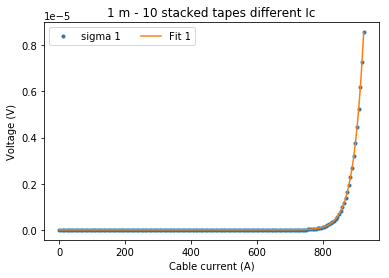

Fit 1: Ic = 929.829570845793, n = 29.898592653762808, Fit-error = 1.1621396751635295e-08
Computing time:  21.86237262099985


<Figure size 432x288 with 0 Axes>

In [28]:
# Generating normal distributions with different standard deviations
#%matplotlib inline
warnings.filterwarnings("ignore") # Force shutting down of warnings

# Start timer 
start = timeit.default_timer()
 
N = 10 # Number of tapes
mu = 100 # mean value for Ic
#sigma = np.array([1,3,5,10,15,20,25,30,40,50,60])
sigma = np.array([1])
Nsample = 500 # Number of samples per each standard deviation 
Imax = 1.25*N*mu # I added a some overcurrent of 25% for the cable current

Ic_array = [] # Array to save Ic from each sample
sd_Ic = []
n_array = [] # Array to save n from each sample
sd_n = []
Error_fit_array = [] # Array to save errors from fitting
sd_error = []

# random1 = int(random.random()*10)
random1 = 0

for i in range(len(sigma)):
    Ic_samples = []
    n_samples = []
    error_samples = []                      
    for j in range(Nsample):
        random2 = int(random.random()*10)
        filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
        #filename = f'{N} tapes sd {sigma[i]} sample {j+1}.cir'
        Ic_dist = np.random.normal(mu, sigma[i], N)
        # Forcing data to be possitive in case Ic is negative
        for k in range(N):
            if Ic_dist[k] <= 0:
                Ic_dist[k] = 10. 
        
        # Generating netlist for specific sample
        #generatenetlist(filename,Ic_dist,N,Imax) 
        
        # Running netlist in ngspice and getting data (cable current and total voltage)
        Icable,Vt = gettingdata(filename)
        
        # Second fitting removing resistive part
        Rt = 0.5E-6/N # Terminal resistance over number of tapes
        Vt_exp = Vt-Icable*Rt # Removing resistive part

        Vt_lim = []
        Icable_lim = []
        
        # Voltage limit
        for l in range(len(Vt_exp)):
            if Vt_exp[l] <= 10e-6: # Limit of the total voltage
                Vt_lim.append(Vt_exp[l])
                Icable_lim.append(Icable[l])

        Vt_lim = np.array(Vt_lim)
        Icable_lim = np.array(Icable_lim)

        # Exponential fitting
        Ic0,n0 = 100*N,30 # Initial values to fit exponential part
        Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
        #print(Ic_e,n_e)
        
        # Saving data from sample
        Ic_samples.append(Ic_e)
        n_samples.append(n_e)   
        
        # Getting curve from fitting 
        Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
        
        # Calculating fitting error
        Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
        error_samples.append(Error)
        #error_treshold = 
        
        # Plotting randomly one case
        if random1 <= 5 and random2 == 2:
            plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
            plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit {sigma[i]}') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
            plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
            plt.xlabel('Cable current (A)')
            plt.ylabel('Voltage (V)')
            plt.title(f'1 m - {N} stacked tapes different Ic')
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
            plt.show()
            plt.savefig('x.png')
            print(f'Fit {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
            random1 += 1
    
    # Arrays for Ic, n, and fit error for samples
    Ic_samples = np.array(Ic_samples)
    n_samples = np.array(n_samples) 
    error_samples = np.array(error_samples)
    
    # Calculating averages and standard deviation of samples
    Ic_array.append(np.average(Ic_samples))
    sd_Ic.append(np.std(Ic_samples))
    
    n_array.append(np.average(n_samples))
    sd_n.append(np.std(n_samples))
    
    Error_fit_array.append(np.average(error_samples))
    sd_error.append(np.std(error_samples))

# Converting averages and standard deviations into array type
Ic_array = np.array(Ic_array)
sd_Ic = np.array(sd_Ic)

n_array = np.array(n_array)
sd_n = np.array(sd_n)

Error_fit_array = np.array(Error_fit_array)
sd_error = np.array(sd_error)

# Saving data from average and sd arrays
fileaveragename = f'{N} tapes - {Nsample} samples'
with open(fileaveragename, 'w') as output:
    output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
    for i in range(len(sigma)):
        output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')

# Stop timer
stop = timeit.default_timer()

print('Computing time: ', stop - start)

# Identical case comparison



Fit identical 1: Ic = 926.3288263888064, n = 30.007030092278523, Fit-error = 5.789267731443301e-08


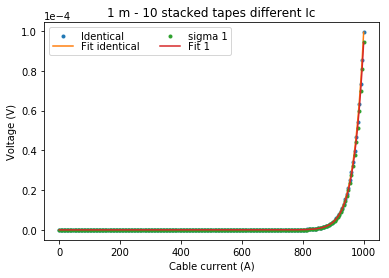

Fit sigma 1: Ic = 927.9684475860637, n = 30.009588421190863, Fit-error = 4.211957261608574e-08
Computing time:  17.53468581299967


<Figure size 432x288 with 0 Axes>

In [33]:
# Generating normal distributions with different standard deviations
%matplotlib inline
#warnings.filterwarnings("ignore") # Force shutting down of warnings

# Start timer 
start = timeit.default_timer()
 
N = 10 # Number of tapes
mu = 100 # mean value for Ic
#sigma = np.array([1,3,5,10,15,20,25,30,40,50,60])
sigma = np.array([1])
Nsample = 500 # Number of samples per each standard deviation 
Imax = 1.25*N*mu # I added a some overcurrent of 25% for the cable current


# Generating identical case
Ic_identical = np.zeros(N)+100
generatenetlist(f'{N} tapes identical',Ic_identical,N,Imax) 

Icable,Vt = gettingdata(filename)
        
# Second fitting removing resistive part
Rt = 0.5E-6/N # Terminal resistance over number of tapes
Vt_exp = Vt-Icable*Rt # Removing resistive part

Vt_lim = []
Icable_lim = []
        
        # Voltage limit
for l in range(len(Vt_exp)):
    if Vt_exp[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt_exp[l])
        Icable_lim.append(Icable[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)

# Exponential fitting
Ic0,n0 = 100*N,30 # Initial values to fit exponential part
Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
#print(Ic_e,n_e)
        
# Getting curve from fitting 
Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
        
# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
#error_treshold = 
       
plt.plot(Icable_lim,Vt_lim,'.',label = f'Identical')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit identical') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
print(f'Fit identical {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')


Ic_array = [] # Array to save Ic from each sample
sd_Ic = []
n_array = [] # Array to save n from each sample
sd_n = []
Error_fit_array = [] # Array to save errors from fitting
sd_error = []

# random1 = int(random.random()*10)
random1 = 0
random2 = int(random.random()*10)

for i in range(len(sigma)):
    Ic_samples = []
    n_samples = []
    error_samples = []                      
    for j in range(Nsample):
        filename = f'{Nsample} samples/{N} tapes sd {sigma[i]} sample {j+1}.cir'
        #filename = f'{N} tapes sd {sigma[i]} sample {j+1}.cir'
        Ic_dist = np.random.normal(mu, sigma[i], N)
        # Forcing data to be possitive in case Ic is negative
        for k in range(N):
            if Ic_dist[k] <= 0:
                Ic_dist[k] = 10. 
        
        # Generating netlist for specific sample
        #generatenetlist(filename,Ic_dist,N,Imax) 
        
        # Running netlist in ngspice and getting data (cable current and total voltage)
        Icable,Vt = gettingdata(filename)
        
        # Second fitting removing resistive part
        Rt = 0.5E-6/N # Terminal resistance over number of tapes
        Vt_exp = Vt-Icable*Rt # Removing resistive part

        Vt_lim = []
        Icable_lim = []
        
        # Voltage limit
        for l in range(len(Vt_exp)):
            if Vt_exp[l] <= 100e-6: # Limit of the total voltage
                Vt_lim.append(Vt_exp[l])
                Icable_lim.append(Icable[l])

        Vt_lim = np.array(Vt_lim)
        Icable_lim = np.array(Icable_lim)

        # Exponential fitting
        Ic0,n0 = 100*N,30 # Initial values to fit exponential part
        Ic_e,n_e = fit_exp10(Icable_lim,Vt_lim,Ic0,n0)
        #print(Ic_e,n_e)
        
        # Saving data from sample
        Ic_samples.append(Ic_e)
        n_samples.append(n_e)   
        
        # Getting curve from fitting 
        Vt_fit_exp = model_func_exp10(Icable_lim,Ic_e,n_e)
        
        # Calculating fitting error
        Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
        error_samples.append(Error)
        #error_treshold = 
        
        # Plotting randomly one case
        if i <= random1 and j == random2:
            plt.plot(Icable_lim,Vt_lim,'.',label = f'sigma {sigma[i]}')
            plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit {sigma[i]}') #: $V = %0.10f *I + Vc*(I/%0.4f)^{%0.4f} $' % (Rt,Ic,n))
            plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
            plt.xlabel('Cable current (A)')
            plt.ylabel('Voltage (V)')
            plt.title(f'1 m - {N} stacked tapes different Ic')
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
            plt.show()
            plt.savefig('x.png')
            print(f'Fit sigma {sigma[i]}: Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
    
    # Arrays for Ic, n, and fit error for samples
    Ic_samples = np.array(Ic_samples)
    n_samples = np.array(n_samples) 
    error_samples = np.array(error_samples)
    
    # Calculating averages and standard deviation of samples
    Ic_array.append(np.average(Ic_samples))
    sd_Ic.append(np.std(Ic_samples))
    
    n_array.append(np.average(n_samples))
    sd_n.append(np.std(n_samples))
    
    Error_fit_array.append(np.average(error_samples))
    sd_error.append(np.std(error_samples))

# Converting averages and standard deviations into array type
Ic_array = np.array(Ic_array)
sd_Ic = np.array(sd_Ic)

n_array = np.array(n_array)
sd_n = np.array(sd_n)

Error_fit_array = np.array(Error_fit_array)
sd_error = np.array(sd_error)

# Saving data from average and sd arrays
fileaveragename = f'{N} tapes - {Nsample} samples'
with open(fileaveragename, 'w') as output:
    output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
    for i in range(len(sigma)):
        output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')

# Stop timer
stop = timeit.default_timer()

print('Computing time: ', stop - start)

### Cells after this point are irrelevant (they were used only for tests)

In [38]:
# Saving data from average and sd arrays
fileaveragename = f'{N} tapes - {Nsample} samples'
with open(fileaveragename, 'w') as output:
    output.write('SD\t Ic\t sd_Ic\t n\t sd_n\t Fit_error\t sd_error\n')
    for i in range(len(sigma)):
        output.write(f'{sigma[i]}\t {Ic_array[i]}\t {sd_Ic[i]}\t {n_array[i]}\t {sd_n[i]}\t {Error_fit_array[i]}\t {sd_error[i]}\n')


In [ ]:
out = subprocess.run(['ngspice', '-b', '10 tapes sd 5 sample 1.cir'], 
stdout=subprocess.PIPE,  stderr=subprocess.PIPE) # This line runs ngspice on shell 

with open('test.txt', 'w') as output:
    for line in out.stdout.decode('ascii').split('\n'):
        print(line)
        output.write(line)

In [ ]:
out = subprocess.run(['ngspice', '-b', '10 tapes sd 5 sample 1.cir'], stdout=subprocess.PIPE,  stderr=subprocess.PIPE)

in_data = False
in_data_after = False
count_dash_line = 0
count_space = 0
data = []
for line in out.stdout.decode('ascii').split('\n'):
    if in_data:
        if line.strip() == '':
            in_data = False
            count_dash_line = 0
            count_space += 1
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
    
    if in_data_after:
        if line.strip() == '':
            in_data_after = False
            count_dash_line = 0
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
        
    if '----' in line:
        count_dash_line += 1
    if count_dash_line == 2 and not in_data:
        in_data = True
    
    if count_dash_line == 1 and count_space == 1 and not in_data_after:
        in_data_after = True
        
data = np.asanyarray(data)
print(data)
Icable = data[:,1]
Vt =  data[:,2] + data[:,3]
V1 = data[:,4]
plt.plot(Icable,Vt)
plt.plot(Icable,V1,'rx')

In [ ]:
f = open("test.txt", "r")
contents =f.read()
#print(contents)

in_data = False
in_data_after = False
count_dash_line = 0
count_space = 0
data = []
for line in contents:
    if in_data:
        if line.strip() == '':
            in_data = False
            count_dash_line = 0
            count_space += 1
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
    
    if in_data_after:
        if line.strip() == '':
            in_data_after = False
            count_dash_line = 0
            continue
        tmp = [float(x) for x in line.split()]
        data.append(tmp)
        
    if '----' in line:
        count_dash_line += 1
    if count_dash_line == 2 and not in_data:
        in_data = True
    
    if count_dash_line == 1 and count_space == 1 and not in_data_after:
        in_data_after = True
        
data = np.asanyarray(data)
print(data)
Icable = data[:,1]
Vt =  data[:,2] 
plt.plot(Icable,Vt)

Questions :

- Do we need to save the data from each distribution or is enough to generate them temporarly and create the .cir file 